In [30]:
import pandas as pd
import numpy as np

In [31]:
df=pd.read_csv('../Data/Spotify_with_genre.csv')

In [32]:
df.head()

,artist_name,track_name,artist_pop,popularity,release_date,genre,track_uri,artist_uri
0,A Thousand Horses,Preachin' To The Choir,37.0,0.0,2017-06-02,Rap,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd
1,Water Liars,You Work Days I Work Nights,29.0,10.0,2012,dnb,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P
2,Chambao,Sera,44.0,31.0,2007-11-06,Rap,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R
3,Jeezy,Big Shit Poppin,69.0,19.0,2007-08-07,Rap,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH
4,La Arrolladora Banda El Limón De Rene Camacho,No La Voy A Engañar,74.0,54.0,2012,Rap,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz


In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
label_encoder = LabelEncoder()

In [35]:
df['artist_name'] = label_encoder.fit_transform(df['artist_name'])
df['genre'] = label_encoder.fit_transform(df['genre'])

In [36]:
df['release_date']=pd.to_datetime(df['release_date'], errors='coerce')

In [37]:
df.dropna(subset=['release_date'], inplace=True)

In [38]:
df['year'] = df['release_date'].dt.year

In [39]:
df.drop(columns=['release_date'], inplace=True)

In [40]:
df.head()

,artist_name,track_name,artist_pop,popularity,genre,track_uri,artist_uri,year
0,34,Preachin' To The Choir,37.0,0.0,1,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd,2017
1,2911,You Work Days I Work Nights,29.0,10.0,2,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P,2012
2,485,Sera,44.0,31.0,1,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R,2007
3,1268,Big Shit Poppin,69.0,19.0,1,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH,2007
4,1525,No La Voy A Engañar,74.0,54.0,1,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz,2012


In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
numerical_features = ['artist_pop', 'popularity']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [153]:
df.head()

,artist_name,track_name,artist_pop,popularity,genre,track_uri,artist_uri,year,cluster,hierarchical_cluster
0,34,Preachin' To The Choir,0.37,0.000000,1,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd,2017,-1,1
1,2911,You Work Days I Work Nights,0.29,0.108696,2,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P,2012,-1,0
2,485,Sera,0.44,0.336957,1,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R,2007,-1,1
3,1268,Big Shit Poppin,0.69,0.206522,1,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH,2007,0,2
4,1525,No La Voy A Engañar,0.74,0.586957,1,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz,2012,-1,2


In [44]:
from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

In [45]:
features_for_clustering = ['artist_pop', 'popularity', 'year', 'genre','artist_name']

In [140]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=2)  # Adjust eps and min_samples as per your data

In [141]:
# Fit DBSCAN clustering
clusters = dbscan.fit_predict(df[features_for_clustering])

In [142]:
# Add cluster labels to dataframe
df['cluster'] = clusters

In [143]:
df

,artist_name,track_name,artist_pop,popularity,genre,track_uri,artist_uri,year,cluster,hierarchical_cluster
0,34,Preachin' To The Choir,0.37,0.000000,1,6JKj9seJCshLVCfBLFp7dS,55RI2GNCfyXr0f14uIdhwd,2017,-1,1
1,2911,You Work Days I Work Nights,0.29,0.108696,2,7L7u4PrNt5WMtVI9lHWlLm,6k3UpifDbb2ox25edM5j3P,2012,-1,0
2,485,Sera,0.44,0.336957,1,12EyOqMPMyAKlKSynICAGN,2qhLqZ1pkiUl5HNrU2Nz0R,2007,-1,1
3,1268,Big Shit Poppin,0.69,0.206522,1,3tCDjKseLQJhShfbeg4m7K,4yBK75WVCQXej1p04GWqxH,2007,0,2
4,1525,No La Voy A Engañar,0.74,0.586957,1,0UICwSsSpUt98XkeCfupFn,5bSfBBCxY8QAk4Pifveisz,2012,-1,2
...,...,...,...,...,...,...,...,...,...,...
5019,2440,Children of the Wild (feat. Mako),0.58,0.478261,7,5uSLlQnpMZqsjZXJxe9kct,4FqPRilb0Ja0TKG3RS3y4s,2016,-1,0
5020,193,Twenty Years,0.43,0.380435,1,2xqjlxsJpuRwNnq5iz9sGX,61YE3whKiuRr83j1yOm5M7,2008,-1,1
5021,2299,Ride It,0.59,0.358696,8,0mel7qfdSZODbHyEBJm5xN,6hyMWrxGBsOx6sWcVj1DqP,2017,-1,0
5022,1689,Loot My Body,0.34,0.369565,0,6DdTte07spm10bOPJrmDuZ,0zprAu7NrzRehc0Q0Jc7mL,2013,-1,2


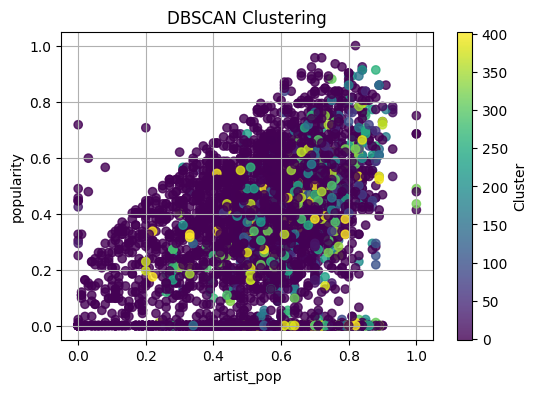

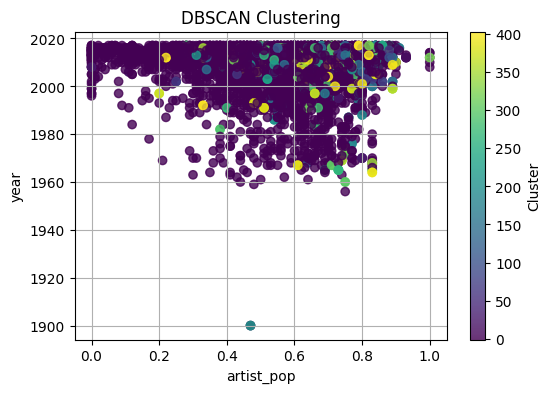

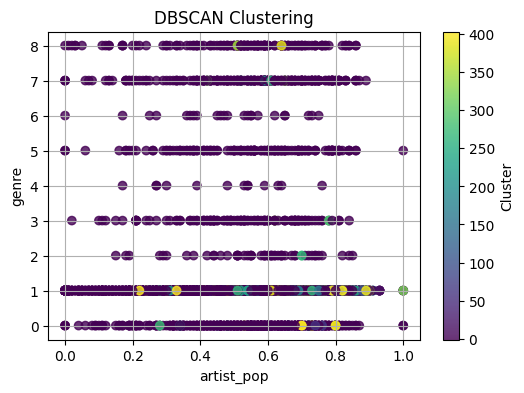

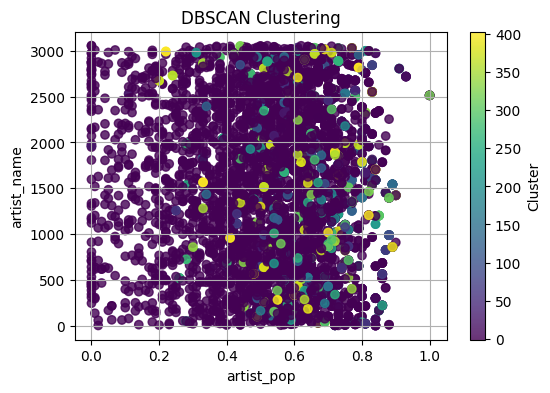

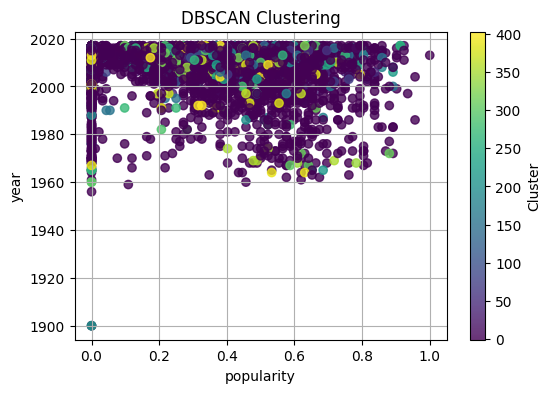

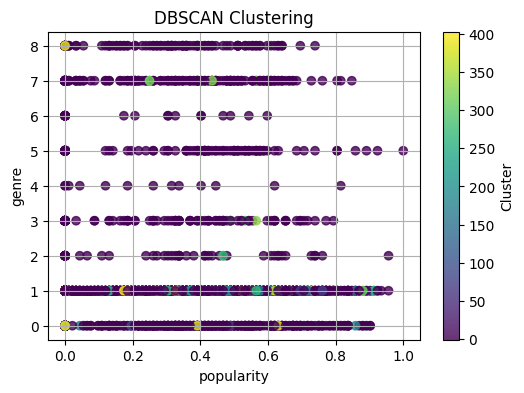

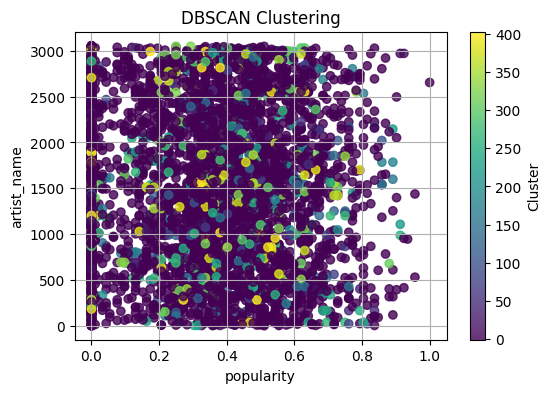

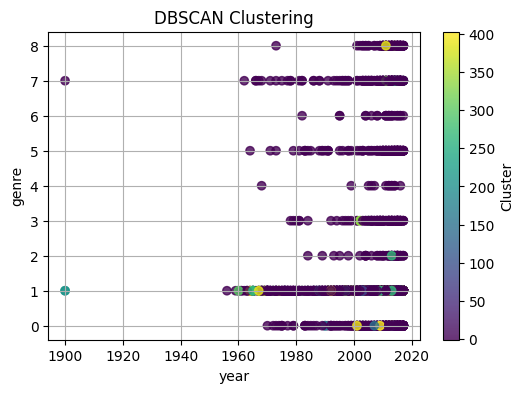

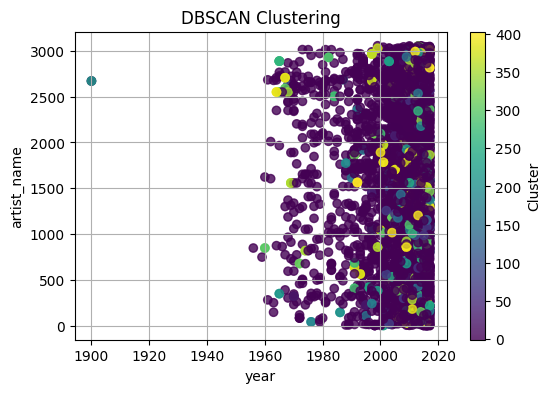

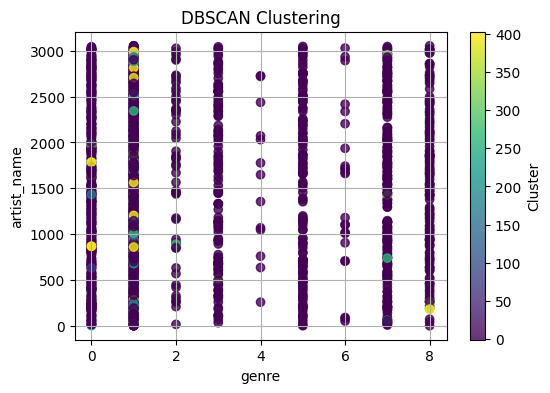

In [144]:
import matplotlib.pyplot as plt

# Plot clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(df['year'], df['popularity'], c=df['cluster'], cmap='viridis', marker='o', alpha=0.8)
# plt.xlabel('Year')
# plt.ylabel('Track Popularity')
# plt.title('DBSCAN Clustering')
# plt.colorbar(label='Cluster')
# plt.grid(True)
# plt.show()


for idx,i in enumerate(features_for_clustering):
    for j in features_for_clustering[idx+1:]:
        if i==j:
            continue
        plt.figure(figsize=(6, 4))
        plt.scatter(df[i], df[j], c=df['cluster'], cmap='viridis', marker='o', alpha=0.8)
        plt.xlabel(i)
        plt.ylabel(j)
        plt.title('DBSCAN Clustering') 
        plt.colorbar(label='Cluster')
        plt.grid(True) 
        plt.show() 
        
    


In [145]:
# Calculate centroid values
centroid_values = df.groupby('cluster')[['artist_pop', 'popularity', 'year', 'genre']].mean()

print("Centroid values:")
print(centroid_values)

Centroid values:
         artist_pop  popularity         year     genre
cluster                                               
-1         0.527253    0.266705  2008.375398  1.715511
 0         0.690000    0.217391  2007.000000  1.000000
 1         0.740000    0.445652  2015.000000  1.000000
 2         0.680000    0.500000  1992.000000  1.000000
 3         0.710000    0.396739  2010.000000  1.000000
...             ...         ...          ...       ...
 399       0.820000    0.005435  2013.000000  1.000000
 400       0.700000    0.000000  2009.000000  0.000000
 401       0.220000    0.255435  2012.000000  1.000000
 402       0.790000    0.353261  2017.000000  1.000000
 403       0.330000    0.320652  1992.000000  1.000000

[405 rows x 4 columns]


In [146]:
# Count the number of clusters formed
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Exclude noise points if present (-1 indicates noise)
print("Number of clusters formed:", num_clusters)

Number of clusters formed: 404


Hierarchical clustering:

In [147]:
from sklearn.cluster import AgglomerativeClustering

In [148]:
# Hierarchical clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarhical_clusters = hc.fit_predict(df[features_for_clustering])

c:\Users\Yuval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [149]:
#Add cluster labels to dataframe
df['hierarchical_cluster'] = hierarhical_clusters

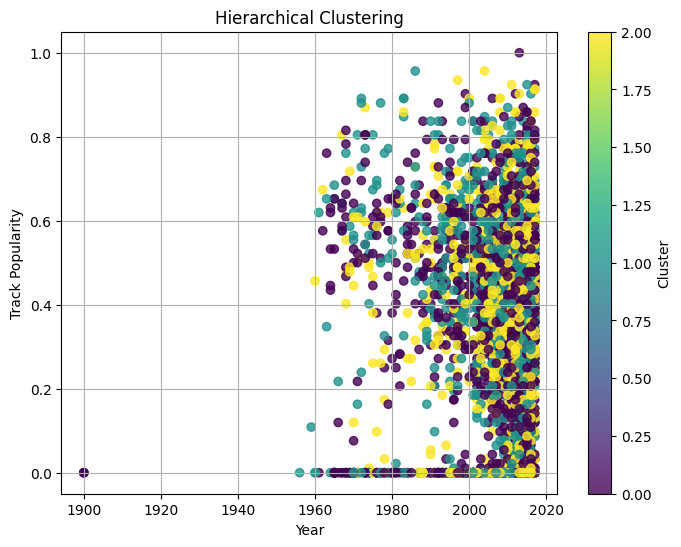

In [150]:
# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['year'], df['popularity'], c=df['hierarchical_cluster'], cmap='viridis', marker='o', alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Track Popularity')
plt.title('Hierarchical Clustering')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [151]:
# Count the number of clusters formed
num_clusters_hc = len(set(hierarhical_clusters))

print("Number of clusters formed by hierarchical clustering:", num_clusters_hc)

Number of clusters formed by hierarchical clustering: 3


In [152]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for DBSCAN
silhouette_score_dbscan = silhouette_score(df[features_for_clustering], clusters)

# Calculate silhouette score for hierarchical clustering
silhouette_score_hc = silhouette_score(df[features_for_clustering], df['hierarchical_cluster'])

print("Silhouette score for DBSCAN:", silhouette_score_dbscan)
print("Silhouette score for hierarchical clustering:", silhouette_score_hc)


Silhouette score for DBSCAN: -0.6219850812458547
Silhouette score for hierarchical clustering: 0.5699247505976412
